Over what distance are mortality events related? In other words, what is the range of spatial autocorrelation in the data? The window we use in the convnets should be large enough to capture this range.

In [1]:
%%capture
!pip install scikit-gstat

In [2]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import skgstat as skg

import os
if 'notebooks' in os.getcwd():
    os.chdir("..")

## Prepare data

We only care about the damage rasters here so we can just get that variable.

In [3]:
ds = xr.open_dataset("data_working/westmort.nc")["mortality"]
ds

<xarray.DataArray 'mortality' (time: 27, y: 652, x: 590)> Size: 42MB
[10386360 values with dtype=float32]
Coordinates:
  * time     (time) int64 216B 1997 1998 1999 2000 2001 ... 2020 2021 2022 2023
  * x        (x) float64 5kB -1.389e+07 -1.389e+07 ... -1.154e+07 -1.154e+07
  * y        (y) float64 5kB 6.278e+06 6.274e+06 ... 3.678e+06 3.674e+06

Isolate the coordinates and values of non-NA cells. The package includes a `SpaceTimeVariogram` class for incorporating distance over space and time. The class does not handle missing values, so we have to pick out cells with a complete time series.

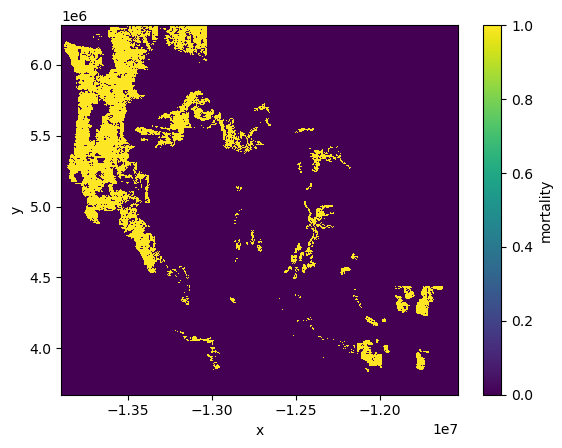

In [4]:
time_slice = slice(2000, 2010)
is_complete = ds.sel(time=time_slice).notnull().all(dim="time")
is_complete.plot()

In [5]:
# Coords: (N, 2) numpy array of x/y position
# Values: (N, T) numpy array of time series
coords = np.stack(np.where(is_complete)).T
print("Coords:", coords.shape, coords.dtype)

y_selector = xr.DataArray(coords[:, 0], dims="points")
x_selector = xr.DataArray(coords[:, 1], dims="points")

values = ds.sel(time=time_slice).isel(y=y_selector, x=x_selector).values.T
values = values.astype(np.dtype(int))
print("Values:", values.shape, values.dtype)

Coords: (37848, 2) int64
Values: (37848, 11) int64


## Marginal variances

In [6]:
total_variance = np.var(values)

space_variance = np.var(np.mean(values, axis=1))
time_variance = total_variance - space_variance

print(f"Total variance: {total_variance:.2f}")
print(f"Space variance: {space_variance:.2f}")
print(f"Time variance:  {time_variance:.2f}")

Total variance: 74.65
Space variance: 22.82
Time variance:  51.84


Variance in time is much larger than variance in space!

## Variograms

Variograms are very expensive to compute. Isolate the spatial lag first by averaging over time.

exponential Variogram
---------------------
Estimator:         matheron
Effective Range:   13.22
Sill:              14.46
Nugget:            0.00
        


/srv/conda/envs/notebook/lib/python3.11/site-packages/skgstat/plotting/variogram_plot.py:123: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


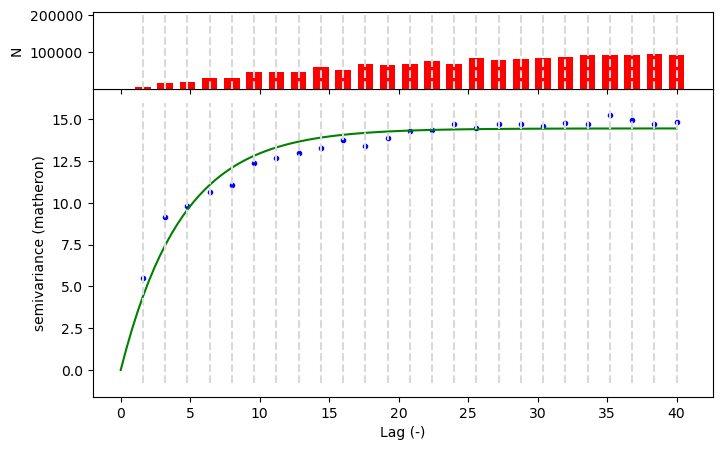

In [7]:
np.random.seed(20250318) # reproducibility
downsample_factor = 5
values_mean_time = np.mean(values, axis=1)
# Random sample so as to not destroy short-range relations
n_to_sample = int(values_mean_time.shape[0] / downsample_factor)
inds_to_use = np.random.choice(values_mean_time.shape[0], n_to_sample, replace=False)
space_var = skg.Variogram(
    coords[inds_to_use], values_mean_time[inds_to_use],
    dist_func="euclidean",
    model="exponential",
    n_lags=25,
    maxlag=40 # * 4 km = 600 km
)
print(space_var)

space_var.plot()
plt.show()

## Spatial Correlograms

Recalculate Moran's I *only* for observations that are a particular distance range apart.

In [8]:
coords_subset = coords[inds_to_use]
values_subset = values_mean_time[inds_to_use]
print("N:", coords_subset.shape[0])

N: 7569


In [9]:
from scipy.spatial import distance_matrix
dist_mtx = distance_matrix(coords_subset, coords_subset)
weight_mtx = 1 / dist_mtx
np.fill_diagonal(weight_mtx, 0)

/tmp/ipykernel_682/1964416964.py:3: RuntimeWarning: divide by zero encountered in divide
  weight_mtx = 1 / dist_mtx


In [10]:
from scipy.stats import pearsonr

km_per_pix = 4
cors = np.zeros(space_var.bins.shape[0]-1)
sigs = np.zeros(cors.shape)
lags = space_var.bins[:-1] * km_per_pix

for i in range(space_var.bins.shape[0]-1):
    lag_low, lag_high = space_var.bins[i], space_var.bins[i+1]
    dist_mask = (dist_mtx >= lag_low) & (dist_mtx < lag_high)
    if not np.any(dist_mask):
        # No observations at this distance
        continue
        
    masked_weights = dist_mask * weight_mtx
    # Lagged average - matrix product of values with matrix (N, N) x (N, 1) = (N, 1)
    # then normalized by per-observation weight sum (N, 1) / (N, 1) = (N, 1)
    lagged_avg = np.matmul(masked_weights, values_subset) / np.sum(masked_weights, axis=1)
    lagged_avg_nonan = lagged_avg[~np.isnan(lagged_avg)]
    values_subset_nonan = values_subset[~np.isnan(lagged_avg)]
    test = pearsonr(lagged_avg_nonan, values_subset_nonan)
    cors[i] = test.statistic
    sigs[i] = test.pvalue < 0.05

print("All correlations significant:", np.all(sigs))

/tmp/ipykernel_682/2724819494.py:18: RuntimeWarning: invalid value encountered in divide
  lagged_avg = np.matmul(masked_weights, values_subset) / np.sum(masked_weights, axis=1)


All correlations significant: True


<div class="alert alert-block alert-info"> 
Since this analysis used a random sample of all pixels, a paper figure like the below should run many samples to get a confidence interval. If we do that we also don't have to worry about significance because we can just see if the CI overlaps with zero.
</div>

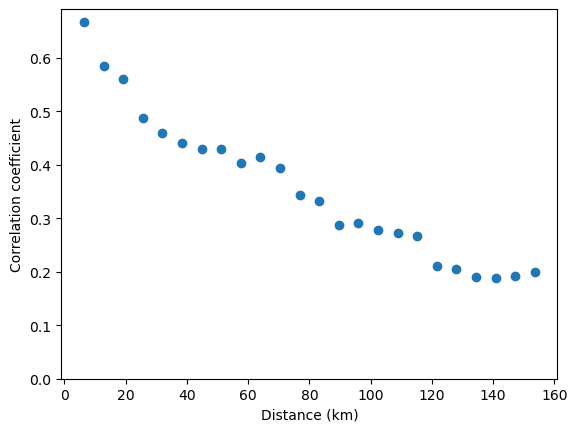

In [11]:
plt.scatter(lags, cors)
plt.xlabel("Distance (km)")
plt.ylabel("Correlation coefficient")
plt.ylim(0, None)
plt.show()